# Summary

Below is a solution for the OpenAI Gym [Taxi-v2](https://gym.openai.com/envs/Taxi-v2/) environment using simple Q-learning.  

Taxi is a game whereby the player must transport a passenger from one location to another.  The board is fixed with some obstacles, but the pickup and dropoff locations are varied between plays between four standard locations.  A example board is:

![image.png](./environment.png)

where possible pickup and dropoff locations are denoted by letters, and the specific pickup and dropoff locations for this instance of the game are denoted by blue and purple text, respectively.  

Valid actions in the game are movements north/south/east/west and attempting a pickup or dropoff.  The reward structure for moves is:

* Successful dropoff: +20 points
* Illeagle pickup/dropoff attempt: -10 points
* All other moves: -1 point

Within the world, any vertical bar represents a wall that cannot be traversed.  Moving into a wall leaves the agent where they started before the move.  

The below solution was crafted to try basic Q-learning with different search strategies ($\epsilon$-greedy and full exploration), and see how that affects the speed at which an agent learns the optimal solution and also the full Q function (including non-optimal states).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from sklearn.externals import joblib

from utilities import Agent, run_episode, run_episodes

For reference, a dict of move translations for each human understanding

In [3]:
# Dict of valid move translation (for printing/manual use), just in case we want it
moves = {
    's': 0,
    'n': 1,
    'e': 2,
    'w': 3,
    'p': 4,
    'd': 5,
}
# Inverse moves
moves.update({v: k for k, v in moves.items()})

Make the taxi environment (do not initialize here - we initialize during looping of run_episodes below)

In [4]:
env = gym.make('Taxi-v2')

Set up our agent settings.  We two search strategies:

* $\epsilon$-Greedy: The agent will choose an action based on:
$$P=\begin{cases}
1-\epsilon + \frac{\epsilon}{N_{actions}}, choose best action\\
\frac{\epsilon}{N_{actions}}, all other actions\\
\end{cases}$$
    Thus we choose the best action 1-$\epsilon$ of the time, choosing a random action the remaining time.  This has the effect of typically marching through the current best guess at an optimal policy, but exploring with probability of $\epsilon$

* Exploration: The agent will always take the action it has previously taken the least.  This prioritizes exploration and establishing a good estimate of the Q function over exploitation of the environment (although whenever we evaluate the current "best" policy of this agent, we of course use a greedy policy that takes the best action)

In [5]:
settings = {
    'e-greedy (0.1)': {'strategy':'egreedy', 'epsilon': 0.1},
    'e-greedy (0.3)': {'strategy':'egreedy', 'epsilon': 0.3},
    'e-greedy (0.5)': {'strategy':'egreedy', 'epsilon': 0.5},
    'Exploration-First': {'strategy':'exploration', },
}

report = {}

n_actions = env.action_space.n
n_states = env.observation_space.n

Train and evaluate each learner by letting the agents play the game 4000 times.  For every 100 plays, report:
* r_recent: Average total reward obtained playing the game from the most recent 100 plays of the evironment (the reward we get using our search strategy)
* r_greedy: Average total reward obtained playing the game using the current best strategy (greedy strategy) learned by the agent, applied to 100 additional random plays of the environment.  This number represents how well the learner is actually learning the optimal gameplay strategy and is a proxy for convergence on the optimal policy
* dq_max_recent: Maximum change in the Q-function estimate being learned by the agent.  This is a rough proxy for convergence on learning the entire game (not just the optimal policy)

In [6]:
for k in settings:
    print(f"Running case {k}")
    agent = Agent(n_states, n_actions, alpha=0.1, gamma=0.9, **settings[k])
    report[k] = run_episodes(env, agent, imax=4000)

Running case e-greedy (0.1)
0: r_recent = -713.00, r_greedy = -831.49, dq_max_recent = 0.0000
100: r_recent = -299.80, r_greedy = -236.00, dq_max_recent = 11.3907
200: r_recent = -210.05, r_greedy = -218.00, dq_max_recent = 10.7717
300: r_recent = -154.69, r_greedy = -193.66, dq_max_recent = 6.8617
400: r_recent = -106.71, r_greedy = -265.12, dq_max_recent = 5.5394
500: r_recent = -85.28, r_greedy = -216.79, dq_max_recent = 4.4455
600: r_recent = -57.17, r_greedy = -184.17, dq_max_recent = 4.7428
700: r_recent = -33.95, r_greedy = -212.77, dq_max_recent = 2.8413
800: r_recent = -25.49, r_greedy = -167.37, dq_max_recent = 2.8151
900: r_recent = -22.47, r_greedy = -184.90, dq_max_recent = 2.7278
1000: r_recent = -12.09, r_greedy = -125.51, dq_max_recent = 3.2249
1100: r_recent = -7.49, r_greedy = -88.50, dq_max_recent = 2.2059
1200: r_recent = -1.59, r_greedy = -72.11, dq_max_recent = 2.5469
1300: r_recent = -1.73, r_greedy = -88.08, dq_max_recent = 2.0009
1400: r_recent = -3.24, r_greed

300: r_recent = -775.55, r_greedy = -109.78, dq_max_recent = 3.9929
400: r_recent = -760.89, r_greedy = -82.40, dq_max_recent = 2.7702
500: r_recent = -767.11, r_greedy = -63.70, dq_max_recent = 2.5924
600: r_recent = -775.41, r_greedy = -35.15, dq_max_recent = 2.1515
700: r_recent = -773.13, r_greedy = -3.92, dq_max_recent = 2.1858
800: r_recent = -763.82, r_greedy = 2.02, dq_max_recent = 2.5781
900: r_recent = -769.78, r_greedy = 5.91, dq_max_recent = 2.1866
1000: r_recent = -766.69, r_greedy = 6.43, dq_max_recent = 1.6433
1100: r_recent = -779.57, r_greedy = 6.53, dq_max_recent = 1.3117
1200: r_recent = -764.28, r_greedy = 8.07, dq_max_recent = 1.6602
1300: r_recent = -767.27, r_greedy = 8.46, dq_max_recent = 1.2837
1400: r_recent = -766.09, r_greedy = 8.36, dq_max_recent = 1.3286
1500: r_recent = -774.60, r_greedy = 8.24, dq_max_recent = 1.1823
1600: r_recent = -774.90, r_greedy = 8.62, dq_max_recent = 1.3021
1700: r_recent = -766.62, r_greedy = 8.47, dq_max_recent = 1.5242
1800: r

Using some simple visualization of the results:

* Plot recent and greedy rewards (described above) versus plays of the game
* Plot dq versus plays of the game

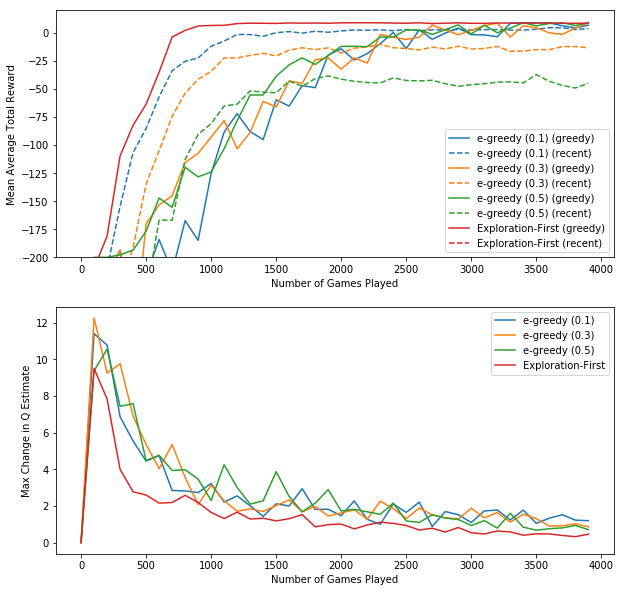

In [7]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
for k in report:
    axs[0].plot(report[k]['i'], report[k]['r_greedy'], label=k + ' (greedy)')
    c = axs[0].get_lines()[-1].get_color()
#     ax.plot(report[k]['i'], np.array(report[k]['r_greedy'])-500, label=k)
    axs[0].plot(report[k]['i'], report[k]['r_window'], color=c, ls='--', label=k + ' (recent)')
    axs[1].plot(report[k]['i'], report[k]['dq_max_window'], color=c, label=k)

axs[0].set(xlabel="Number of Games Played", 
           ylabel="Mean Average Total Reward")
axs[1].set(xlabel="Number of Games Played", 
           ylabel="Max Change in Q Estimate")
    
axs[0].legend()
axs[1].legend()
axs[0].set_ylim(-200, 20)
plt.show()

We can also visualize how consistent the results are for the greedy policies.  Below shows the greedy policies from the above figure overlaid with a shaded area showing +-1 standard deviation.

(-200, 20)

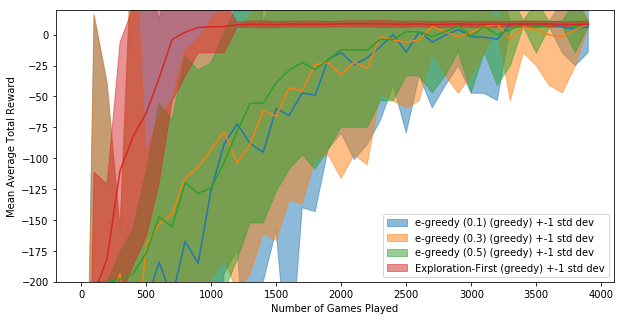

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
for k in report:
    ax.plot(report[k]['i'], report[k]['r_greedy'])
    c = ax.get_lines()[-1].get_color()
#     ax.plot(report[k]['i'], np.array(report[k]['r_greedy'])-500, label=k)
    ax.fill_between(report[k]['i'], 
                    np.array(report[k]['r_greedy']) - np.array(report[k]['r_greedy_std']),
                    np.array(report[k]['r_greedy']) + np.array(report[k]['r_greedy_std']), color=c, alpha=0.5,
                             label=k + ' (greedy) +-1 std dev')

ax.set(xlabel="Number of Games Played", 
           ylabel="Mean Average Total Reward")
ax.legend()
ax.set_ylim(-200, 20)

Thus, we see the exploration strategy in this case is the most efficient to finding a good policy.  This is likely influenced by how simple this environment is (only ~500 states, 6 actions per state) - in cases with more complex state spaces we'd expect much worse performance from an exploration-first strategy.